# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Set-up-data" data-toc-modified-id="Set-up-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set up data</a></div><div class="lev2 toc-item"><a href="#Find-data-overlap" data-toc-modified-id="Find-data-overlap-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find data overlap</a></div><div class="lev2 toc-item"><a href="#Reduce-frequency-of-ground_df-for-1-to-1-comparison" data-toc-modified-id="Reduce-frequency-of-ground_df-for-1-to-1-comparison-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Reduce frequency of ground_df for 1-to-1 comparison</a></div><div class="lev2 toc-item"><a href="#Window-based-metrics" data-toc-modified-id="Window-based-metrics-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Window based metrics</a></div><div class="lev1 toc-item"><a href="#NSRDB-data" data-toc-modified-id="NSRDB-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>NSRDB data</a></div><div class="lev2 toc-item"><a href="#Tree-parameter-optimization" data-toc-modified-id="Tree-parameter-optimization-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Tree parameter optimization</a></div><div class="lev3 toc-item"><a href="#Optimize-tree" data-toc-modified-id="Optimize-tree-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Optimize tree</a></div><div class="lev2 toc-item"><a href="#Test-on-NSRDB-data" data-toc-modified-id="Test-on-NSRDB-data-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Test on NSRDB data</a></div>

# Introduction

This notebook will explore how closely NSRDB satellite data and RTC ground data agree on irradiance measurements.  We will also look at the agreement between modeled irradiance from NSRDB and that supplied by PVLIB.  Ideally we hope to see that measured irradiances and modeled irradiances are close to one another for both collection methods.  If the NSRDB and ground based RTC data are different, we hope that they are different on a similar scale.

# Load data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools

import pvlib
import utils

import model_free

import concurrent.futures
from IPython.display import Image

from sklearn import tree
from sklearn import ensemble
from sklearn import metrics

# np.set_printoptions(precision=4)
%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [2]:
nsrdb_df = pd.read_pickle('./abq_nsrdb_df.pkl')
ground_df = pd.read_pickle('./abq_ground_df.pkl')

# Set up data

## Find data overlap

In [3]:
intersection = nsrdb_df.index.intersection(ground_df.index)
EARLIEST_IDX = intersection[0]
LATEST_IDX = intersection[-1]
print('NSRDB date range: {} -> {}'.format(nsrdb_df.index[0], nsrdb_df.index[-1]))
print('Ground date range: {} -> {}'.format(ground_df.index[0], ground_df.index[-1]))
print('Earliest intersection: {}, latest intersection: {}'.format(EARLIEST_IDX, LATEST_IDX))

NSRDB date range: 1997-12-31 17:00:00-07:00 -> 2015-12-31 16:30:00-07:00
Ground date range: 2015-01-08 22:31:00-07:00 -> 2017-04-06 01:00:00-06:00
Earliest intersection: 2015-01-08 23:00:00-07:00, latest intersection: 2015-12-31 16:30:00-07:00


In [4]:
intersection = intersection[intersection >= '10-01-2015']

## Reduce frequency of ground_df for 1-to-1 comparison

In [5]:
ground_df = ground_df.loc[intersection]

## Window based metrics

In [6]:
nsrdb_df = utils.metric_calc(nsrdb_df, 3, 1, 'abs_diff_ratio stat', 'Clearsky GHI stat')

In [7]:
ground_df = utils.metric_calc(ground_df, 3, 1, 'abs_diff_ratio stat', 'Clearsky GHI stat')

# NSRDB data

## Tree parameter optimization

In [8]:
cols = ['GHI', 
        'Clearsky GHI stat',
        'abs_diff_ratio stat', 
        'metric mean', 
        'metric std', 
        'metric min', 
        'metric max', 
        'metric grad',
        'metric range',
        'metric grad mean',
        'metric grad std',
        'metric grad max',
        'metric grad min',
        'metric grad range',
        'GHI grad',
        'GHI grad mean',
        'GHI grad std',
        'GHI grad max',
        'GHI grad min',
        'GHI grad range',
        'model grad',
        'model grad mean',
        'model grad std',
        'model grad max',
        'model grad min',
        'model grad range',
        'sky_status']

In [9]:
# tree.export_graphviz(dt, out_file='5_abq_default_dt_stat.dot', feature_names=[x.replace('stat', '') for x in cols[:-1]], class_names=['cloudy', 'clear'])
# !dot -Tpng 5_abq_default_dt_stat.dot -o 5_abq_default_dt_stat.png
# Image('5_abq_default_dt_stat.png')

# Runnning this cell is extremely time consuming!!

Tree is overly complex and difficult to interpret.  Will start by limiting the depth of the tree (using cross val).

### Optimize tree

In [10]:
# param_grid = {'max_leaf_nodes': list(range(2, 21, 2))}
param_grid = {
              'max_leaf_nodes': np.arange(8, 31, 2), 
              'max_depth': np.arange(3, 10, 1)
             }
dt = tree.DecisionTreeClassifier(class_weight='balanced')
# dt = ensemble.RandomForestClassifier(class_weight='balanced', n_estimators=100)
clf_cv = utils.fit_model_cv_grid(dt, nsrdb_df, cols, param_grid)
dt = clf_cv.best_estimator_

<IPython.core.display.Javascript object>

In [11]:
dt.max_leaf_nodes, dt.max_depth, dt.min_samples_split

(30, 7, 2)

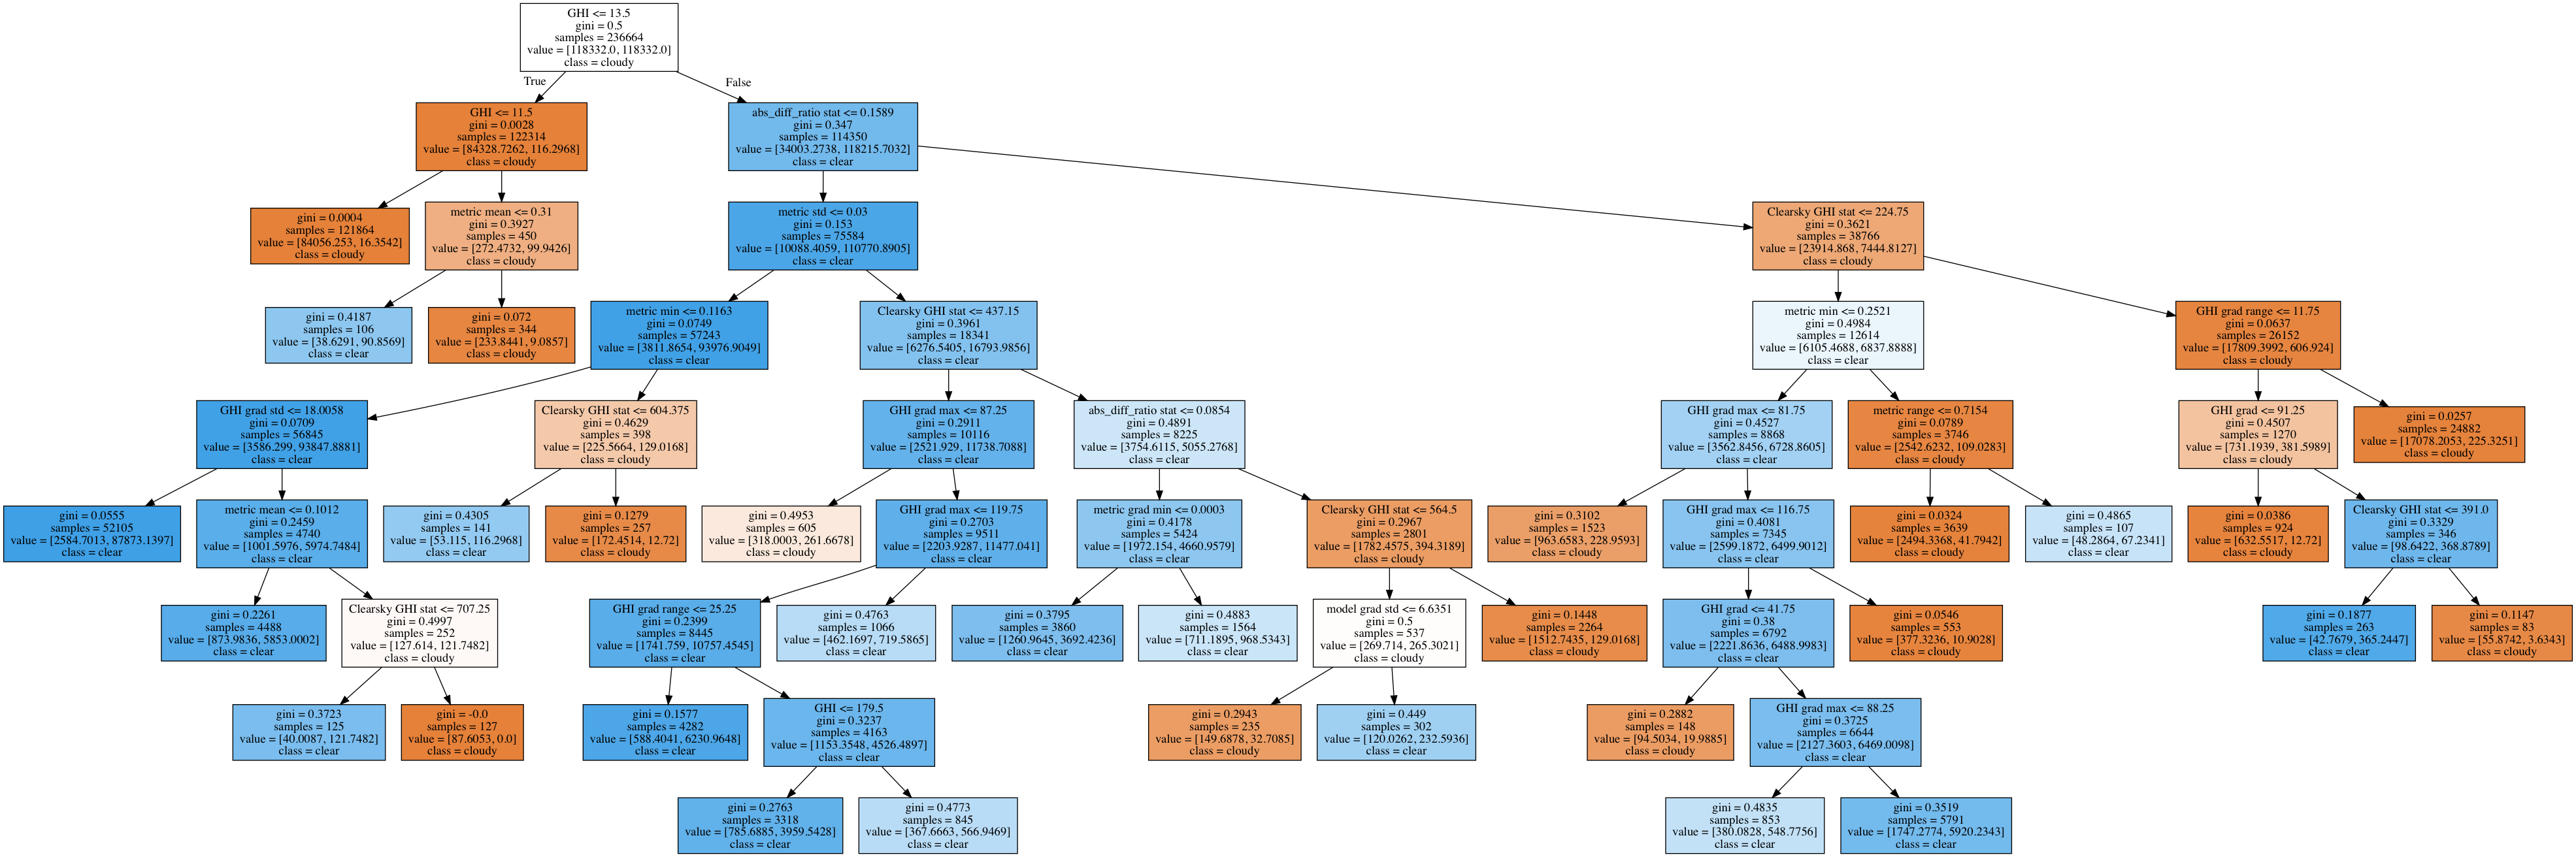

In [12]:
tree.export_graphviz(dt, out_file='5_abq_opt_dt_stat.dot', feature_names=[x for x in cols[:-1]], class_names=['cloudy', 'clear'], filled=True)
!dot -Tpng 5_abq_opt_dt_stat.dot -o 5_abq_opt_dt_stat.png
Image('5_abq_opt_dt_stat.png')

In [13]:
scores = clf_cv.cv_results_['mean_test_score']
min(scores)

0.91486242098502524

## Test on NSRDB data

In [14]:
train_df = nsrdb_df[nsrdb_df.index < '01-01-2015']
test_df = nsrdb_df[nsrdb_df.index >= '01-01-2015']

In [15]:
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=30, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
predicted_clear = dt.predict(test_df[cols[:-1]])

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df[~(predicted_clear) & (test_df['sky_status'] == 1)].index, 
                test_df[~(predicted_clear) & (test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)].index, 
                test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['sky_status'] == 1) & (predicted_clear)].index,
                test_df[(test_df['sky_status'] == 1) & (predicted_clear)]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


<IPython.core.display.Javascript object>

In [18]:
conf_mat = metrics.confusion_matrix(test_df['sky_status'], predicted_clear)
utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])

<IPython.core.display.Javascript object>

DT missing early morning and late evenings again.  In general though, the performance is very good.  There are limited cases where the DT detection looks incorrect. 

In [19]:
train_df = nsrdb_df
test_df = ground_df[ground_df.index >= '10-01-2015']
# test_df = ground_df.loc[intersection]

In [20]:
# cols = ['GHI', 'Clearsky GHI stat', 'abs_diff_ratio stat', 'sky_status']
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=30, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [21]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

In [22]:
train_df = train_df.loc[intersection]
test_df = test_df.loc[intersection]

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

p6 = ax.scatter(test_df[test_df['sky_status']].index,
                test_df[test_df['sky_status']]['GHI'],
                marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


<IPython.core.display.Javascript object>

In [24]:
conf_mat = metrics.confusion_matrix(train_df['sky_status'], test_df['dt_clear'])
utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])

<IPython.core.display.Javascript object>

In [25]:
ground_df = pd.read_pickle('./abq_ground_df.pkl')

In [26]:
ground_df = ground_df[(ground_df.index >= '10-01-2015') & (ground_df.index < '01-01-2016')]

In [27]:
ground_df = utils.metric_calc(ground_df, 10, 1, 'abs_diff_ratio stat', 'Clearsky GHI stat')

In [28]:
test_df = ground_df

In [29]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

x = train_df[train_df.index.isin(test_df.index) & (train_df['sky_status'])].index
# for x in train_df[train_df.index.isin(test_df.index) & (train_df['sky_status'])].index:
#     p3 = ax.scatter(x, test_df[test_df.index == x]['GHI'], color='green', marker='o', edgecolor='green', facecolor='none', s=100)
#p3 = ax.axvline(train_df[train_df.index.isin(test_df.index) & (train_df['sky_status'])].index)#,
               # ymin=0, ymax=test_df[intersection].index.isin(train_df['sky_status'])['GHI'])
               # train_df[train_df.index.isin(test_df.index) & (train_df['sky_status'])]['GHI'],
                # marker='o', edgecolor='green', facecolor='none', label='NSRDB clear', zorder=10, s=100)
p3 = ax.scatter(x, test_df[test_df.index.isin(x)]['GHI'], color='green', marker='o', edgecolor='green', facecolor='none', s=100)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~test_df['sky_status']].index,
                test_df[(test_df['dt_clear'] == 1) & ~test_df['sky_status']]['GHI'],
                marker='x', color='blue', label='DT clear only', zorder=10)

p4 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & test_df['sky_status']].index,
                test_df[~(test_df['dt_clear'] == 1) & test_df['sky_status']]['GHI'],
                marker='x', color='black', label='PVLib clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & test_df['sky_status']].index,
                test_df[(test_df['dt_clear'] == 1) & test_df['sky_status']]['GHI'],
                marker='x', color='red', label='PVLib + DT', zorder=10)

# p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
#                 test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
#                 marker='x', color='black', label='DT & NSRDB', zorder=10)

# p6 = ax.scatter(test_df[test_df['sky_status']].index,
#                 test_df[test_df['sky_status']]['GHI'],
#                 marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


<IPython.core.display.Javascript object>

In [ ]:
ground_df = pd.read_pickle('./abq_ground_df.pkl')

In [ ]:
ground_df = ground_df.resample('5min').mean()

In [ ]:
ground_df = ground_df[(ground_df.index >= '10-01-2015') & (ground_df.index < '01-01-2016')]

In [ ]:
ground_df = utils.metric_calc(ground_df, 3, 1, 'abs_diff_ratio stat', 'Clearsky GHI stat')

In [ ]:
test_df = ground_df

In [ ]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

In [ ]:
test_df['sky_status'] = np.rint(test_df['sky_status']).astype(bool)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(train_df[train_df.index.isin(test_df.index) & (train_df['sky_status'])].index,
                train_df[train_df.index.isin(test_df.index) & (train_df['sky_status'])]['GHI'],
                marker='o', edgecolor='green', facecolor='none', label='NSRDB clear', zorder=10, s=100)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~test_df['sky_status']].index,
                test_df[(test_df['dt_clear'] == 1) & ~test_df['sky_status']]['GHI'],
                marker='x', color='blue', label='DT clear only', zorder=10)

p4 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & test_df['sky_status']].index,
                test_df[~(test_df['dt_clear'] == 1) & test_df['sky_status']]['GHI'],
                marker='x', color='black', label='PVLib clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & test_df['sky_status']].index,
                test_df[(test_df['dt_clear'] == 1) & test_df['sky_status']]['GHI'],
                marker='x', color='red', label='PVLib + DT', zorder=10)

# p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
#                 test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
#                 marker='x', color='black', label='DT & NSRDB', zorder=10)

# p6 = ax.scatter(test_df[test_df['sky_status']].index,
#                 test_df[test_df['sky_status']]['GHI'],
#                 marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


In [ ]:
ground_df = pd.read_pickle('./abq_ground_df.pkl')

In [ ]:
ground_df = ground_df.resample('30min').mean()

In [ ]:
ground_df = ground_df[(ground_df.index >= '10-01-2015') & (ground_df.index < '01-01-2016')]

In [ ]:
ground_df = utils.metric_calc(ground_df, 3, 1, 'abs_diff_ratio stat', 'Clearsky GHI stat')

In [ ]:
test_df = ground_df

In [ ]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

In [ ]:
test_df['sky_status'] = np.rint(test_df['sky_status']).astype(bool)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(train_df[train_df.index.isin(test_df.index) & (train_df['sky_status'])].index,
                train_df[train_df.index.isin(test_df.index) & (train_df['sky_status'])]['GHI'],
                marker='o', edgecolor='green', facecolor='none', label='NSRDB clear', zorder=10, s=100)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~test_df['sky_status']].index,
                test_df[(test_df['dt_clear'] == 1) & ~test_df['sky_status']]['GHI'],
                marker='x', color='blue', label='DT clear only', zorder=10)

p4 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & test_df['sky_status']].index,
                test_df[~(test_df['dt_clear'] == 1) & test_df['sky_status']]['GHI'],
                marker='x', color='black', label='PVLib clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & test_df['sky_status']].index,
                test_df[(test_df['dt_clear'] == 1) & test_df['sky_status']]['GHI'],
                marker='x', color='red', label='PVLib + DT', zorder=10)

# p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
#                 test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
#                 marker='x', color='black', label='DT & NSRDB', zorder=10)

# p6 = ax.scatter(test_df[test_df['sky_status']].index,
#                 test_df[test_df['sky_status']]['GHI'],
#                 marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')
